## Training and Quality control for nuclear segmentation

StarDist uses a shape representation based on star-convex polygons for nuclei in an image to predict the presence and the shape of these nuclei. This network is based on an adapted U-Net network architecture. 

To train and test the network, we use a dataset from the 2018 DSB nuclear segmentation challenge as well as few more nuclei that we have labelled from widefield images of DAPI stained tissue sections. 

In [3]:
# import libraries 
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imageio as imio
import os

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import limit_gpu_memory

from stardist import fill_label_holes, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D

from src.utlis.data_augmentation import augmenter

from src.utlis.segmentation_stardist_model import segment_objects_stardist2d
from stardist.matching import matching_dataset


In [ ]:
os.path.join(os.path.dirname(os.getcwd()),'example_data/nuc_labels.tif')

In [4]:
os.getcwd()

'/home/pathy_s/Documents/Tissue_Analysis/notebook'

In [2]:
# setup the paths 

path_to_raw_image='/home/pathy_s/Documents/ground_truths/raw_train/'
path_to_GT_labels='/home/pathy_s/Documents/ground_truths/GT_train/'
path_to_raw_image_test='/home/pathy_s/Documents/ground_truths/raw_test/'
path_to_GT_labels_test='/home/pathy_s/Documents/ground_truths/GT_test/'
#temp='/home/pathy_s/Documents/ground_truths/temp'
path_to_model='/home/pathy_s/Documents/Tissue_Analysis/models/'
output_dir= "/home/pathy_s/Documents/ground_truths/v2/"

path_to_output_segmented_images_train="/home/pathy_s/Documents/ground_truths/Segmented_labels_train/"
path_to_output_segmented_images_test="/home/pathy_s/Documents/ground_truths/Segmented_labels_test/"
#Path(temp).mkdir(parents=True, exist_ok=True)

Path(output_dir).mkdir(parents=True, exist_ok=True)
Path(path_to_output_segmented_images_train).mkdir(parents=True, exist_ok=True)
Path(path_to_output_segmented_images_test).mkdir(parents=True, exist_ok=True)

In [21]:
#read in the training data which would of pairs of input image and label instances.
X = sorted(glob(path_to_raw_image +'*.tif'))
Y = sorted(glob(path_to_GT_labels +'*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
X = list(map(imread,X))
Y = list(map(imread,Y))
#Normalize images and fill small label holes.
X = [normalize(x,1,99.8,axis=(0,1)) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]
#Split into train and validation datasets.
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

100%|██████████| 453/453 [00:01<00:00, 261.10it/s]

number of images: 453
- training:       385
- validation:      68


In [4]:
#set up the configuration
conf = Config2D (
    n_rays       = 32,
    grid         = (2,2),
    use_gpu      = True and gputools_available(),
    n_channel_in = 1)
limit_gpu_memory(None, allow_growth=True)

#Setup and train the model
model = StarDist2D(conf, name='Nuclear_segmentation_v1', basedir=path_to_model)
history=model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
#optimize NMS threshold
model.optimize_thresholds(X_val, Y_val)
# convert the history.history dict to a pandas DataFrame:     
lossData = pd.DataFrame(history.history) 

/home/pathy_s/anaconda3/lib/python3.8/site-packages/csbdeep/models/base_model.py:148: UserWarning: output path for model already exists, files may be overwritten: /home/pathy_s/Documents/Tissue_Analysis/models/Nuclear_segmentation_v1
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.570276, nms_thresh=0.3.
Epoch 1/400
100/100 [==============================] - 10s 99ms/step - loss: 2.3192 - prob_loss: 0.3607 - dist_loss: 9.7925 - prob_kld: 0.2850 - dist_relevant_mae: 9.7920 - dist_relevant_mse: 188.2805 - val_loss: 2.3231 - val_prob_loss: 0.3408 - val_dist_loss: 9.9115 - val_prob_kld: 0.2677 - val_dist_relevant_mae: 9.9110 - val_dist_relevant_mse: 196.2387
Epoch 2/400
100/100 [==============================] - 6s 65ms/step - loss: 1.7174 - prob_loss: 0.2705 - dist_loss: 7.2346 - prob_kld: 0.1969 - dist_relevant_mae: 7.2337 - dist_relevant_mse: 111.1279 - val_loss: 1.6659 - val_prob_loss: 0.2718 - val_dist_loss: 6.9706 - val_prob_kld: 0.1986 - val_dist_relevant_mae: 6.9694 - val_dist_relevant_mse: 88.3593
Epoch 3/400
100/100 [==============================] - 6s 61ms/step - loss: 1.4601 - prob_loss: 0.2394 - dist_loss: 6.1035 - prob_kld: 0.1651 - dist_relevant_mae: 6.1025 - dist_relevant

Epoch 24/400
100/100 [==============================] - 6s 58ms/step - loss: 0.5662 - prob_loss: 0.0880 - dist_loss: 2.3909 - prob_kld: 0.0144 - dist_relevant_mae: 2.3902 - dist_relevant_mse: 17.0433 - val_loss: 0.5972 - val_prob_loss: 0.0871 - val_dist_loss: 2.5502 - val_prob_kld: 0.0139 - val_dist_relevant_mae: 2.5493 - val_dist_relevant_mse: 20.0494
Epoch 25/400
100/100 [==============================] - 6s 58ms/step - loss: 0.5538 - prob_loss: 0.0900 - dist_loss: 2.3189 - prob_kld: 0.0147 - dist_relevant_mae: 2.3182 - dist_relevant_mse: 16.4329 - val_loss: 0.5900 - val_prob_loss: 0.0869 - val_dist_loss: 2.5154 - val_prob_kld: 0.0137 - val_dist_relevant_mae: 2.5147 - val_dist_relevant_mse: 18.7217
Epoch 26/400
100/100 [==============================] - 6s 58ms/step - loss: 0.5446 - prob_loss: 0.0886 - dist_loss: 2.2804 - prob_kld: 0.0140 - dist_relevant_mae: 2.2796 - dist_relevant_mse: 15.4499 - val_loss: 0.5974 - val_prob_loss: 0.0874 - val_dist_loss: 2.5501 - val_prob_kld: 0.0142 

100/100 [==============================] - 6s 57ms/step - loss: 0.4224 - prob_loss: 0.0816 - dist_loss: 1.7039 - prob_kld: 0.0111 - dist_relevant_mae: 1.7034 - dist_relevant_mse: 8.5403 - val_loss: 0.5268 - val_prob_loss: 0.0841 - val_dist_loss: 2.2133 - val_prob_kld: 0.0109 - val_dist_relevant_mae: 2.2128 - val_dist_relevant_mse: 11.6534
Epoch 71/400
100/100 [==============================] - 6s 58ms/step - loss: 0.4360 - prob_loss: 0.0870 - dist_loss: 1.7450 - prob_kld: 0.0114 - dist_relevant_mae: 1.7445 - dist_relevant_mse: 8.6132 - val_loss: 0.4541 - val_prob_loss: 0.0846 - val_dist_loss: 1.8475 - val_prob_kld: 0.0115 - val_dist_relevant_mae: 1.8471 - val_dist_relevant_mse: 9.9136
Epoch 72/400
100/100 [==============================] - 6s 58ms/step - loss: 0.4168 - prob_loss: 0.0866 - dist_loss: 1.6508 - prob_kld: 0.0116 - dist_relevant_mae: 1.6503 - dist_relevant_mse: 7.9083 - val_loss: 0.4628 - val_prob_loss: 0.0921 - val_dist_loss: 1.8533 - val_prob_kld: 0.0189 - val_dist_releva

100/100 [==============================] - 6s 60ms/step - loss: 0.4015 - prob_loss: 0.0864 - dist_loss: 1.5755 - prob_kld: 0.0115 - dist_relevant_mae: 1.5750 - dist_relevant_mse: 7.4026 - val_loss: 0.4354 - val_prob_loss: 0.0836 - val_dist_loss: 1.7590 - val_prob_kld: 0.0104 - val_dist_relevant_mae: 1.7584 - val_dist_relevant_mse: 8.8916
Epoch 117/400
100/100 [==============================] - 6s 59ms/step - loss: 0.3736 - prob_loss: 0.0804 - dist_loss: 1.4659 - prob_kld: 0.0097 - dist_relevant_mae: 1.4654 - dist_relevant_mse: 6.6527 - val_loss: 0.4269 - val_prob_loss: 0.0835 - val_dist_loss: 1.7172 - val_prob_kld: 0.0103 - val_dist_relevant_mae: 1.7167 - val_dist_relevant_mse: 8.6863
Epoch 118/400
100/100 [==============================] - 6s 59ms/step - loss: 0.4131 - prob_loss: 0.0871 - dist_loss: 1.6300 - prob_kld: 0.0103 - dist_relevant_mae: 1.6295 - dist_relevant_mse: 7.4822 - val_loss: 0.4192 - val_prob_loss: 0.0832 - val_dist_loss: 1.6798 - val_prob_kld: 0.0100 - val_dist_relev

100/100 [==============================] - 6s 57ms/step - loss: 0.3525 - prob_loss: 0.0789 - dist_loss: 1.3684 - prob_kld: 0.0093 - dist_relevant_mae: 1.3679 - dist_relevant_mse: 5.8226 - val_loss: 0.3762 - val_prob_loss: 0.0827 - val_dist_loss: 1.4673 - val_prob_kld: 0.0095 - val_dist_relevant_mae: 1.4669 - val_dist_relevant_mse: 6.6454
Epoch 163/400
100/100 [==============================] - 6s 58ms/step - loss: 0.3528 - prob_loss: 0.0835 - dist_loss: 1.3468 - prob_kld: 0.0103 - dist_relevant_mae: 1.3464 - dist_relevant_mse: 5.7155 - val_loss: 0.3746 - val_prob_loss: 0.0826 - val_dist_loss: 1.4600 - val_prob_kld: 0.0094 - val_dist_relevant_mae: 1.4596 - val_dist_relevant_mse: 6.4680
Epoch 164/400
100/100 [==============================] - 6s 60ms/step - loss: 0.3709 - prob_loss: 0.0882 - dist_loss: 1.4136 - prob_kld: 0.0110 - dist_relevant_mae: 1.4132 - dist_relevant_mse: 6.8081 - val_loss: 0.3798 - val_prob_loss: 0.0829 - val_dist_loss: 1.4848 - val_prob_kld: 0.0097 - val_dist_relev

100/100 [==============================] - 6s 59ms/step - loss: 0.3414 - prob_loss: 0.0832 - dist_loss: 1.2912 - prob_kld: 0.0092 - dist_relevant_mae: 1.2908 - dist_relevant_mse: 5.3986 - val_loss: 0.4014 - val_prob_loss: 0.0855 - val_dist_loss: 1.5795 - val_prob_kld: 0.0123 - val_dist_relevant_mae: 1.5791 - val_dist_relevant_mse: 7.9662
Epoch 209/400
100/100 [==============================] - 6s 57ms/step - loss: 0.3497 - prob_loss: 0.0826 - dist_loss: 1.3355 - prob_kld: 0.0089 - dist_relevant_mae: 1.3351 - dist_relevant_mse: 5.5014 - val_loss: 0.3637 - val_prob_loss: 0.0824 - val_dist_loss: 1.4063 - val_prob_kld: 0.0093 - val_dist_relevant_mae: 1.4059 - val_dist_relevant_mse: 6.0359
Epoch 210/400
100/100 [==============================] - 6s 58ms/step - loss: 0.3586 - prob_loss: 0.0836 - dist_loss: 1.3755 - prob_kld: 0.0099 - dist_relevant_mae: 1.3750 - dist_relevant_mse: 5.9388 - val_loss: 0.3790 - val_prob_loss: 0.0832 - val_dist_loss: 1.4790 - val_prob_kld: 0.0100 - val_dist_relev

100/100 [==============================] - 6s 59ms/step - loss: 0.3398 - prob_loss: 0.0822 - dist_loss: 1.2881 - prob_kld: 0.0084 - dist_relevant_mae: 1.2877 - dist_relevant_mse: 5.2244 - val_loss: 0.3622 - val_prob_loss: 0.0825 - val_dist_loss: 1.3987 - val_prob_kld: 0.0093 - val_dist_relevant_mae: 1.3983 - val_dist_relevant_mse: 5.7891
Epoch 255/400
100/100 [==============================] - 6s 59ms/step - loss: 0.3303 - prob_loss: 0.0829 - dist_loss: 1.2371 - prob_kld: 0.0082 - dist_relevant_mae: 1.2367 - dist_relevant_mse: 5.1038 - val_loss: 0.3834 - val_prob_loss: 0.0832 - val_dist_loss: 1.5009 - val_prob_kld: 0.0100 - val_dist_relevant_mae: 1.5005 - val_dist_relevant_mse: 6.1768
Epoch 256/400
100/100 [==============================] - 6s 57ms/step - loss: 0.3392 - prob_loss: 0.0822 - dist_loss: 1.2848 - prob_kld: 0.0082 - dist_relevant_mae: 1.2844 - dist_relevant_mse: 5.2167 - val_loss: 0.3595 - val_prob_loss: 0.0822 - val_dist_loss: 1.3864 - val_prob_kld: 0.0090 - val_dist_relev

100/100 [==============================] - 6s 59ms/step - loss: 0.3071 - prob_loss: 0.0816 - dist_loss: 1.1273 - prob_kld: 0.0075 - dist_relevant_mae: 1.1269 - dist_relevant_mse: 4.5110 - val_loss: 0.3644 - val_prob_loss: 0.0827 - val_dist_loss: 1.4087 - val_prob_kld: 0.0095 - val_dist_relevant_mae: 1.4082 - val_dist_relevant_mse: 5.8560
Epoch 300/400
100/100 [==============================] - 6s 58ms/step - loss: 0.3028 - prob_loss: 0.0817 - dist_loss: 1.1053 - prob_kld: 0.0076 - dist_relevant_mae: 1.1049 - dist_relevant_mse: 4.0133 - val_loss: 0.3502 - val_prob_loss: 0.0827 - val_dist_loss: 1.3376 - val_prob_kld: 0.0095 - val_dist_relevant_mae: 1.3372 - val_dist_relevant_mse: 5.2805
Epoch 301/400
100/100 [==============================] - 6s 56ms/step - loss: 0.3134 - prob_loss: 0.0837 - dist_loss: 1.1484 - prob_kld: 0.0080 - dist_relevant_mae: 1.1480 - dist_relevant_mse: 4.6564 - val_loss: 0.3594 - val_prob_loss: 0.0826 - val_dist_loss: 1.3841 - val_prob_kld: 0.0094 - val_dist_relev

100/100 [==============================] - 6s 61ms/step - loss: 0.3044 - prob_loss: 0.0808 - dist_loss: 1.1181 - prob_kld: 0.0074 - dist_relevant_mae: 1.1177 - dist_relevant_mse: 4.1668 - val_loss: 0.3485 - val_prob_loss: 0.0821 - val_dist_loss: 1.3319 - val_prob_kld: 0.0089 - val_dist_relevant_mae: 1.3315 - val_dist_relevant_mse: 5.2813
Epoch 346/400
100/100 [==============================] - 6s 58ms/step - loss: 0.2848 - prob_loss: 0.0791 - dist_loss: 1.0282 - prob_kld: 0.0068 - dist_relevant_mae: 1.0279 - dist_relevant_mse: 3.5237 - val_loss: 0.3500 - val_prob_loss: 0.0823 - val_dist_loss: 1.3382 - val_prob_kld: 0.0091 - val_dist_relevant_mae: 1.3378 - val_dist_relevant_mse: 5.2425
Epoch 347/400
100/100 [==============================] - 6s 59ms/step - loss: 0.2905 - prob_loss: 0.0794 - dist_loss: 1.0554 - prob_kld: 0.0070 - dist_relevant_mae: 1.0551 - dist_relevant_mse: 3.5176 - val_loss: 0.3658 - val_prob_loss: 0.0828 - val_dist_loss: 1.4154 - val_prob_kld: 0.0096 - val_dist_relev

100/100 [==============================] - 6s 58ms/step - loss: 0.2860 - prob_loss: 0.0814 - dist_loss: 1.0228 - prob_kld: 0.0068 - dist_relevant_mae: 1.0224 - dist_relevant_mse: 3.4041 - val_loss: 0.3478 - val_prob_loss: 0.0822 - val_dist_loss: 1.3277 - val_prob_kld: 0.0091 - val_dist_relevant_mae: 1.3274 - val_dist_relevant_mse: 5.3691
Epoch 391/400
100/100 [==============================] - 6s 60ms/step - loss: 0.2752 - prob_loss: 0.0783 - dist_loss: 0.9845 - prob_kld: 0.0065 - dist_relevant_mae: 0.9842 - dist_relevant_mse: 3.2416 - val_loss: 0.3575 - val_prob_loss: 0.0823 - val_dist_loss: 1.3761 - val_prob_kld: 0.0091 - val_dist_relevant_mae: 1.3758 - val_dist_relevant_mse: 5.3106
Epoch 392/400
100/100 [==============================] - 6s 59ms/step - loss: 0.2890 - prob_loss: 0.0817 - dist_loss: 1.0366 - prob_kld: 0.0069 - dist_relevant_mae: 1.0362 - dist_relevant_mse: 4.0650 - val_loss: 0.3463 - val_prob_loss: 0.0825 - val_dist_loss: 1.3190 - val_prob_kld: 0.0093 - val_dist_relev

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:41<00:13,  2.74s/it, 0.535 -> 0.759]


Using optimized values: prob_thresh=0.535023, nms_thresh=0.4.
Saving to 'thresholds.json'.


### Quality checks 

We check the visualise the loss curves for the training and validation sets to make sure that the training is complete.

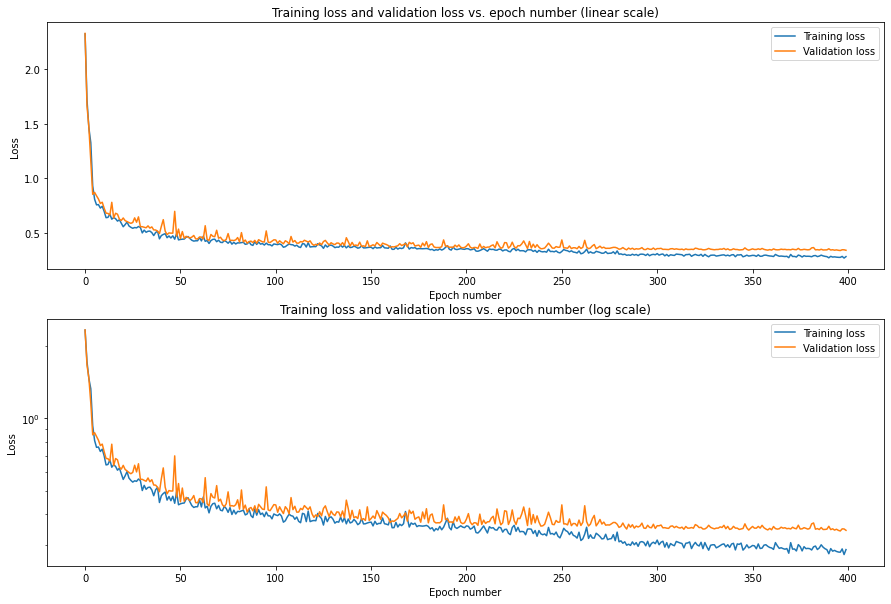

In [7]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(range(400),lossData['loss'], label='Training loss')
plt.plot(range(400),lossData['val_loss'], label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (linear scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()

plt.subplot(2,1,2)
plt.semilogy(range(400),lossData['loss'], label='Training loss')
plt.semilogy(range(400),lossData['val_loss'], label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (log scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()
plt.show()

lossData.to_csv(output_dir+"training_losses.csv")

Further, we also obtain object level errors using IoU based metrics 

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.535023, nms_thresh=0.4.


100%|██████████| 9/9 [00:16<00:00,  1.88s/it]


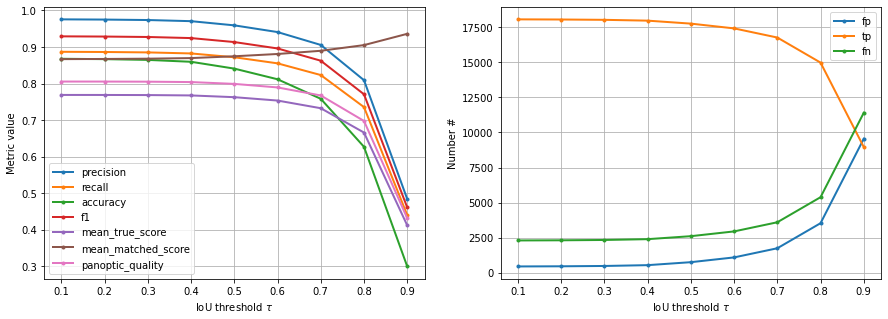

In [36]:
#perform the segmentation task
segment_objects_stardist2d(image_dir = path_to_raw_image,
                           output_dir_labels = path_to_output_segmented_images_train,
                           use_pretrained = False, 
                           output_dir_ijroi = False,
                           model_name='Nuclear_segmentation_v1',
                           model_dir = path_to_model)
#read in the images and results 
X = sorted(glob(path_to_raw_image+"*.tif"))
Y = sorted(glob(path_to_GT_labels+"*.tif"))
Y_pred = sorted(glob(path_to_output_segmented_images_train +"*.tif"))
X = list(map(imread,X))
Y = list(map(imread,Y))
Y_pred = list(map(imread,Y_pred))

#Compute the segmentation efficiency metrics for the whole dataset
#IoU thresholds to compute
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax1.set_xlabel(r'IoU threshold $\tau$')
    ax1.set_ylabel('Metric value')
    ax1.grid()
    ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax2.set_xlabel(r'IoU threshold $\tau$')
    ax2.set_ylabel('Number #')
    ax2.grid()
    ax2.legend();
seg_efficiency_tot=pd.DataFrame(stats)
seg_efficiency_tot.to_csv(output_dir+"train_segmentation_efficiencies_whole_dataset.csv")

Finally we use a test dataset of images that the model has not see evaluate the model

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.535023, nms_thresh=0.4.


100%|██████████| 9/9 [00:03<00:00,  2.92it/s]


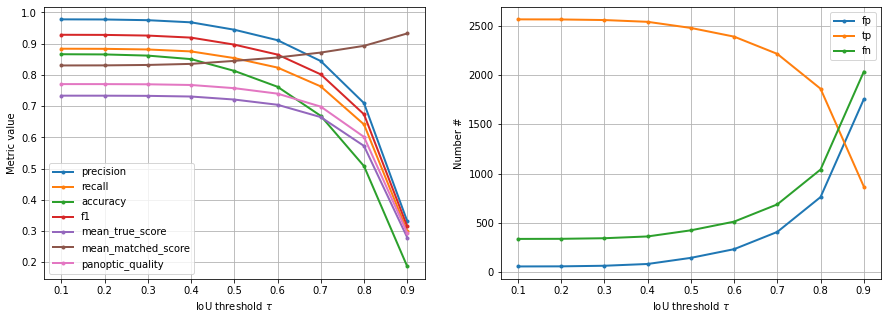

In [37]:
#perform the segmentation task
segment_objects_stardist2d(image_dir = path_to_raw_image_test,
                           output_dir_labels = path_to_output_segmented_images_test,
                           use_pretrained = False,
                           output_dir_ijroi = False,
                           model_name='Nuclear_segmentation_v1',
                           model_dir = path_to_model)
#read in the images and results 
X = sorted(glob(path_to_raw_image_test+"*.tif"))
Y = sorted(glob(path_to_GT_labels_test+"*.tif"))
Y_pred = sorted(glob(path_to_output_segmented_images_test +"*.tif"))
X = list(map(imread,X))
Y = list(map(imread,Y))
Y_pred = list(map(imread,Y_pred))

#Compute the segmentation efficiency metrics for the whole dataset
#IoU thresholds to compute
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax1.set_xlabel(r'IoU threshold $\tau$')
    ax1.set_ylabel('Metric value')
    ax1.grid()
    ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax2.set_xlabel(r'IoU threshold $\tau$')
    ax2.set_ylabel('Number #')
    ax2.grid()
    ax2.legend();
#Save the results
seg_efficiency_tot.to_csv(output_dir+"test_segmentation_efficiencies_whole_dataset.csv")

In [43]:
pd.DataFrame( {"Level" : ['whole_dataset'],
               "Recall_0.7_IoU" : [seg_efficiency_tot['recall'][thresholds.index(0.7)]],
               "Average_F1" : [np.mean(seg_efficiency_tot['f1'])],
               "Accuracy" : [seg_efficiency_tot['accuracy'][thresholds.index(0.7)]]})


,Level,Recall_0.7_IoU,Average_F1,Accuracy
0,whole_dataset,0.823307,0.845957,0.758323
